<a href="https://colab.research.google.com/github/jewbe22/eecs4415_Big_data/blob/main/project_1/Task_1_Word_Count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EECS 4415 - Task 1
## Word Count in Spark

### Setup

Let's set up Spark on your Colab environment.  Run the cell below!

In [1]:
!pip install pyspark
!pip install -U -q PyDrive2
#the output 'xxx is not a symbolic link' will not affect your implementation or execution
#to fix 'xxx is not a symbolic link', you can comment out the lines starting from !mv xxxx
#you may need to replace xxx.11 with the correct version if other errors come up after colab update
#to get the correct version, use !ls /usr/local/lib to find out
!mv /usr/local/lib/libtbbmalloc_proxy.so.2 /usr/local/lib/libtbbmalloc_proxy.so.2.backup
!mv /usr/local/lib/libtbbmalloc.so.2 /usr/local/lib/libtbbmalloc.so.2.backup
!mv /usr/local/lib/libtbbbind_2_5.so.3 /usr/local/lib/libtbbbind_2_5.so.3.backup
!mv /usr/local/lib/libtbb.so.12 /usr/local/lib/libtbb.so.12.backup
!mv /usr/local/lib/libtbbbind_2_0.so.3 /usr/local/lib/libtbbbind_2_0.so.3.backup
!mv /usr/local/lib/libtbbbind.so.3 /usr/local/lib/libtbbbind.so.3.backup
!ln -s /usr/local/lib/libtbbmalloc_proxy.so.2.11 /usr/local/lib/libtbbmalloc_proxy.so.2
!ln -s /usr/local/lib/libtbbmalloc.so.2.11 /usr/local/lib/libtbbmalloc.so.2
!ln -s /usr/local/lib/libtbbbind_2_5.so.3.11 /usr/local/lib/libtbbbind_2_5.so.3
!ln -s /usr/local/lib/libtbb.so.12.11 /usr/local/lib/libtbb.so.12
!ln -s /usr/local/lib/libtbbbind_2_0.so.3.11 /usr/local/lib/libtbbbind_2_0.so.3
!ln -s /usr/local/lib/libtbbbind.so.3.11 /usr/local/lib/libtbbbind.so.3
# !sudo ldconfig
#If error related to the above execution occurs, you can try commenting out the above 12 lines under pip install PyDrive2 (not included)
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#the output 'xxx is not a symbolic link' will not affect your implementation or execution
#to fix 'xxx is not a symbolic link', you can comment out the lines starting from !mv xxxx
#you may need to replace xxx.11 with the correct version if other errors come up after colab update
#to get the correct version, use !ls /usr/local/lib to find out

openjdk-8-jdk-headless is already the newest version (8u422-b05-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Now we authenticate a Google Drive client to download the file we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [2]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
id='1SE6k_0YukzGd5wK-E4i6mG83nydlfvSa'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('pg100.txt')

If you executed the cells above, you should be able to see the file *pg100.txt* under the "Files" tab on the left panel.

### Your task

If you successfully run the setup stage, you are ready to work on the *pg100.txt* file which contains a copy of the complete works of Shakespeare.

Write a Spark application which outputs the number of words that start with each letter. This means that for every letter, we want to count the total number of (non-unique) words that start with a specific letter. (If a specific (aka unique) word that starts with letter 'a' appears N times, it should be counted in words starting with 'a' N times.)

In your implementation, **ignore the letter case**, i.e., consider all words as lower case. Also, ignore all words that **start** with a non-alphabetic character. You should output word counts for the **entire document**, inclusive of the title, author, and the main texts. If you encounter words broken as a result of new lines, e.g. "pro-ject" where the segment after the dash sign is on a new line, no special processing is needed and you can safely consider it as two words ("pro" and "ject").

Your outputs will be graded on a range -- if your differences from the ground-truths are within an error threshold of 5, you'll be considered correct.

**Hint:**
1. split only on space (' ') but not hyphen/dash ('-') or other symbols.
2. you may find spark function split (https://spark.apache.org/docs/latest/rdd-programming-guide.html) helpful, but you don't need to restrict to them as long as you can satisfy your goal.

Clarification:

1. If a word 'project' is separated into two lines in the form of 'pro-' in the first line and 'ject' in the second line, it should be treated as two words. However, for the word 'self-love' that appears in a single line, it should be treated as one word starting with letter 's'.

In [4]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
import pandas as pd

# create the Spark Session
spark = SparkSession.builder.getOrCreate()

# create the Spark Context
sc = spark.sparkContext

Perform map and reduce operations using Spark transformations and actions. See the following programming guide for these transformations and actions (among other resources that you can find online): https://spark.apache.org/docs/latest/rdd-programming-guide.html).

In [13]:
# YOUR CODE HERE (map operations)
def mapping(word):
  return (word[0], 1)

input = sc.textFile('pg100.txt')

word_pairs = input.map(lambda x: x.lower())
word_pairs = word_pairs.flatMap(lambda x: x.split(' '))
word_pairs = word_pairs.filter(lambda x: x != '' and x.isalpha())
word_pairs = word_pairs.map(lambda x: x.strip())
word_pairs = word_pairs.map(lambda x: mapping(x))


In [14]:
# YOUR CODE HERE (reduce operations)
def reduce_func(x, y):
  return x + y

word_count = word_pairs.reduceByKey(reduce_func)


Compute and print for words that start with a, d, e, j, k, n, q, t, y, z

In [15]:
# YOUR CODE HERE
start_with = ['a', 'd', 'e', 'j', 'k', 'n', 'q', 't', 'y', 'z']
word_count_filtered = word_count.filter(lambda x: x[0] in start_with)

for i in sorted(word_count_filtered.collect(), key=lambda x: x[0]):
  print(i)


('a', 72155)
('d', 19492)
('e', 12666)
('j', 1474)
('k', 5861)
('n', 19183)
('q', 1299)
('t', 105860)
('y', 20646)
('z', 32)


Make a plot based on this printed data.

<Axes: xlabel='starts_with'>

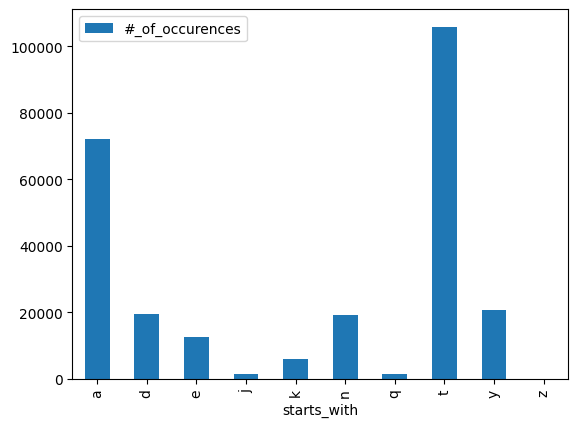

In [25]:
#YOUR CODE HERE
pl = word_count_filtered.toDF()
pl = pl.withColumnRenamed('_1', 'starts_with')
pl = pl.withColumnRenamed('_2','#_of_occurences')

pl = pl.toPandas()
pl.sort_values(by=['starts_with'],inplace=True)
pl.plot(kind='bar', x='starts_with', y='#_of_occurences')


Write a paragraph of conclusions below summarizing your insights.

This result shows that the number of occurneces of the words starts with 'a' and 't' are considerably higher than the others. One of the possible reason for this is that English articles, a/an/the, are the most oftenly used words in typical english writings.

Once you obtained the desired results, **head over to eClass and submit your solution for this Colab**!